# Import modules

In [2]:
!pip3 install pdflatex qiskit ipywidgets quantum-decomp pylatexenc import-ipynb
!wget https://raw.githubusercontent.com/hkhetawat/QArithmetic/master/QArithmetic.py
!wget https://raw.githubusercontent.com/hkhetawat/QArithmetic/master/qft.py

Defaulting to user installation because normal site-packages is not writeable


--2022-09-23 10:22:40--  https://raw.githubusercontent.com/hkhetawat/QArithmetic/master/QArithmetic.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13886 (14K) [text/plain]
Saving to: ‘QArithmetic.py.2’

QArithmetic.py.2    100%[===================>]  13,56K  --.-KB/s    in 0s      

2022-09-23 10:22:41 (36,4 MB/s) - ‘QArithmetic.py.2’ saved [13886/13886]

--2022-09-23 10:22:41--  https://raw.githubusercontent.com/hkhetawat/QArithmetic/master/qft.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1820 (1,8K) [text/plain]
Saving

In [1]:
import import_ipynb, qiskit, functools, QArithmetic
import numpy as np
import math
import matplotlib as plt
from itertools import chain
from qiskit import Aer, IBMQ, QuantumRegister, ClassicalRegister, QuantumCircuit, execute, assemble, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import noise
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram

In [30]:
class groverPhase():
    
    '''Compactar en cajas la combinación lineal???'''
    
    def __init__(self, initH = False):
        self.initH = initH # Ensambla con el H inicial?
    
    def subCircAssemble(func):
        
        
        def inner(self, qCircuit, *args):
            registerClass = type(QuantumRegister(1, 'dummy'))
            dummyCircuitSize = 0
            wireList = []
            wires =[]
            
            for var in args:
                if type(var) == registerClass:
                    wires.append(var)
            for wire in wires:
                dummyCircuitSize += len(wire)
                wireList += list(wire)
            
            
            dummyCircuit = QuantumCircuit(*wires, name = f'{func.__name__}')

            qCircuit.append(func(self, dummyCircuit, *args), wireList)
            
            
            
        return inner
    
    def substraction():
        '''operador de diferencia'''
        pass
    
    @subCircAssemble
    def addition(self, qCircuit, threadsA, threadsB):
        '''operador de suma'''
        numThreads = len(threadsA)
        
        QArithmetic.add(qCircuit, threadsA, threadsB, numThreads)
        
        return qCircuit
        
            
    @subCircAssemble        
    def product(self, qCircuit, threadOfGen, threadOfLambda, threadOfLinear):
        
        num = len(threadOfGen)
        QArithmetic.mult(qCircuit, threadOfGen, threadOfLambda, threadOfLinear[:2*num], num)
        
        return qCircuit
    
    def linearCombination(self, qCircuit, threadsOfGen, numberOfGen, threadsOfLambda, threadsOfLinear):
        '''operador de combinación lineal'''
        
        for i in range(len(threadsOfGen)):
            self.product(qCircuit, threadsOfGen[i], threadsOfLambda[i], threadsOfLinear[i])
        
        for i in range(numberOfGen-1):
           
            self.addition(qCircuit, threadsOfLinear[i], threadsOfLinear[i+1])
            
        return qCircuit
    
    @subCircAssemble
    def substractSought(self, qCircuit, threadsOfSought, threadsOfLinearCom):
        QArithmetic.sub(qCircuit, threadsOfSought, threadsOfLinearCom, len(threadsOfSought)-1)
        
        return qCircuit
    
    
    @subCircAssemble
    def isCero(self, qCircuit, control, target):
        
        qCircuit.x(control)
        qCircuit.mct(control, target)
        
        return qCircuit
        
    
    def semigroupMembershipOracle():
        pass # Ensambla el oráculo.
    
    def difussor():
        '''Crea un difusor en los hilos implicados'''
        pass
    
    def induceSuperposition(self, qCircuit, threads):
        
        if not self.initH:
            
            for i in range(len(threads)):
                qCircuit.h(threads[i])
            self.initH = True
            
            
    def assembleCircuit():
        '''Ensambla el circuito con una iter de oracle and difussor'''
        pass
        

In [31]:
class semigroupMembership(groverPhase):
    
    '''El numero opt. de iter (sol simple) es sqrt(2^n)'''
    
    def __init__(self, soughtElement, sizeOfLambda = None, *generators):
        super().__init__()
        self.soughtElement = soughtElement
        self.generators = generators
        self.numberOfGenerators = len(generators)
        if sizeOfLambda==None:
            self.sizeOfLambda = max([math.ceil(math.log2(gen)) for gen in generators])
        else:
            self.sizeOfLambda = sizeOfLambda
            
            
        '''Numero de iteraciones del algoritmod e grover'''
        self.numbIter = math.floor(math.sqrt(self.numberOfGenerators*self.sizeOfLambda))
        
        
    def dec2binQR(self, qReg, number): # ****
        '''Toma un valor decimal y un registro, introduce el equiv. binairo en el registro.'''
        
        binExp = bin(number) #−> 0bxxxxx...
            
        if len(qReg)<len(binExp)-2:
            print(f"error al convertir en binario{len(qReg)} and {len(binExp)-2}")
            return
        i=0
        # De derecha a izquierda
        while binExp[-(i+1)]!='b':
            if binExp[-(i+1)]=='1':
              self.circ.x(qReg[i])
            i += 1
        del(i, binExp)
    
    def setUpThreads(self):
        
        sizeOfGenerators = self.sizeOfLambda # Tienen que coincidir para poder multiplicarlos.
        
        
        self.threadsOfGenerators = [QuantumRegister(sizeOfGenerators, f's{i}')
                                    for i in range(self.numberOfGenerators)]
        
        self.threadsOfLambda = [QuantumRegister(self.sizeOfLambda, f'lambda{i}')
                                    for i in range(self.numberOfGenerators)]
        
        # Numero de iteraciones, harían falta más para LinCom
        self.threadsOfLinCom = [QuantumRegister(self.sizeOfLambda*2 + j, f'linearCom{j}')
                                for j in range(self.numberOfGenerators-1)]
        
        # This need one more thread to perform substraction
        self.threadsOfLinCom.append(QuantumRegister(self.sizeOfLambda*2 + self.numberOfGenerators,
                                                    f'linearCom{self.numberOfGenerators-1}'))
        
        # Same size to substract
        self.threadsOfSought = [QuantumRegister(self.sizeOfLambda*2 + self.numberOfGenerators, 'a')]
        
        self.threadPhaseKickback = QuantumRegister(1, 'b')      
            
        self.circ = QuantumCircuit(*self.threadsOfGenerators, *self.threadsOfLambda,
                                   *self.threadsOfLinCom, *self.threadsOfSought, self.threadPhaseKickback,
                                   name='Semigroup Membership Algorithm')
        
        
    def setUpValues(self):
        
        for i in range(self.numberOfGenerators):
            self.dec2binQR(self.threadsOfGenerators[i], self.generators[i])
        self.dec2binQR(self.threadsOfSought[0], self.soughtElement)

    def setUpPhaseKickback(self):
        self.circ.x(self.threadPhaseKickback)
        self.circ.h(self.threadPhaseKickback)
        
    

In [32]:
test1 = semigroupMembership(3, None, 2, 3) # The input of the generators isn't efficient. It's not flexible.
test1.setUpThreads() # Crea los hilos
test1.setUpValues() # Asigna valores a los generadores y el elemento buscado
test1.
test1.induceSuperposition(test1.circ, test1.threadsOfLambda)
test1.setUpPhaseKickback()
test1.linearCombination(test1.circ, test1.threadsOfGenerators, test1.numberOfGenerators
                        ,test1.threadsOfLambda, test1.threadsOfLinCom)

test1.substractSought(test1.circ, test1.threadsOfSought[0], test1.threadsOfLinCom[-1])


test1.isCero(test1.circ, test1.threadsOfLinCom[-1], test1.threadPhaseKickback)

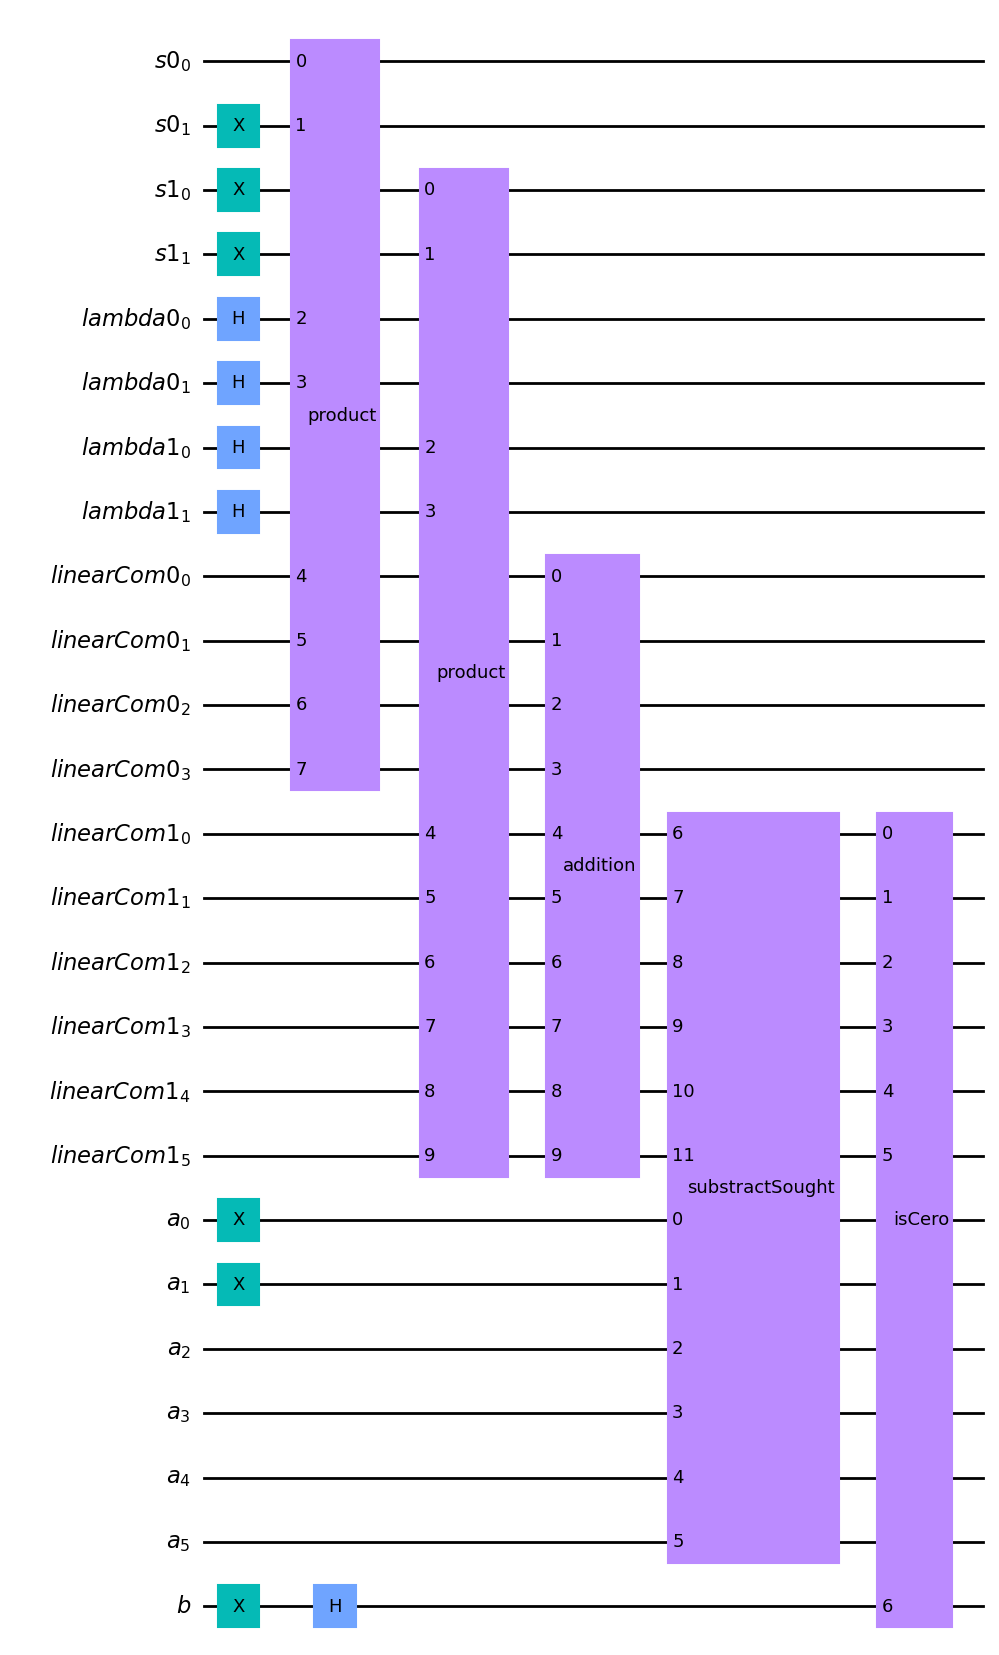

In [33]:
test1.circ.draw('mpl')

In [187]:

del(test1)

In [37]:
help(QArithmetic.sub)

Help on function sub in module QArithmetic:

sub(circ, a, b, n)
    # Subtractor that takes |a>|b> to |a>|a-b>.
    # |a> has length n+1 (left padded with a zero).
    # |b> has length n+1 (left padded with a zero).

